In [2]:
import pandas as pd
pd.read_csv('data.csv')

,index,neutral,pro_saf,pro_rsf,anti_saf,anti_rsf
0,1,0,0,0,0,1
1,2,0,1,0,0,0
2,3,0,0,0,0,1
3,4,1,0,0,0,0
4,5,0,0,0,1,0
5,6,0,0,1,0,0
6,7,0,0,1,0,0
7,8,0,0,0,0,1
8,9,0,0,0,1,0
9,10,0,1,0,0,0


In [1]:
from eda import read_data, get_xy, get_tweets_embeddings, embeddings_pca, TweetClassifer, TweetsDataset, score_model, calculate_pos_weights, load_openai_embs
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from torch.utils.data import DataLoader
import warnings
import torch
import joblib
import os
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
sns.set_theme()
warnings.filterwarnings('ignore')




test_size = 0.3
labels = ['pro RSF', 'anti RSF', 'anti SAF', 'pro SAF', 'Pro peace,', 'anti peace', 'Pro War',
       'anti war', 'pro civilian', 'anti civilians', 'no polarisation', 'Geopolticis', 'Sudanese', 'Not Sudanese']
src = 'openai'
random_state = 42

embddings_dict = {}
embddings_dict_path = f'embeddings_{src}_{random_state}_{test_size}.joblib'


df = read_data()
df = df.dropna()


X, Y, codes = get_xy(df, labels_cols=labels)
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)
codes = codes.reset_index(drop=True)



X_train, X_test, Y_train, Y_test, codes_train, codes_test = train_test_split(X, Y, codes, test_size=test_size, random_state=random_state)
X_val, X_test, Y_val, Y_test, codes_val, codes_test = train_test_split(X_test, Y_test, codes_test, test_size=test_size, random_state=random_state)
print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

if os.path.exists(embddings_dict_path):
    print('Loading embeddings from cache')
    embddings_dict = joblib.load(embddings_dict_path)
    train_embeddings = embddings_dict['train']
    val_embeddings = embddings_dict['val']
    test_embeddings = embddings_dict['test']
else:
    print('Calculating embeddings')
    train_embeddings = get_tweets_embeddings(X_train.to_list(), codes=codes_train.to_list(), src=src)
    val_embeddings   = get_tweets_embeddings(X_val.to_list()  , codes=codes_val.to_list()  , src=src)
    test_embeddings  = get_tweets_embeddings(X_test.to_list() , codes=codes_test.to_list() , src=src)
    embddings_dict['train'] = train_embeddings
    embddings_dict['val'] = val_embeddings
    embddings_dict['test'] = test_embeddings
    joblib.dump(embddings_dict, embddings_dict_path)


train_labels = torch.tensor(Y_train.to_numpy(), dtype=torch.float32)
val_labels = torch.tensor(Y_val.to_numpy(), dtype=torch.float32)
test_labels = torch.tensor(Y_test.to_numpy(), dtype=torch.float32)

num_classes = len(labels)
embeddings_dim = train_embeddings.shape[1]
print(f'Num Classes = {num_classes}')
print(f'Emb Dim = {embeddings_dim}')





Train: 606, Val: 182, Test: 79
Loading embeddings from cache
Num Classes = 14
Emb Dim = 3072


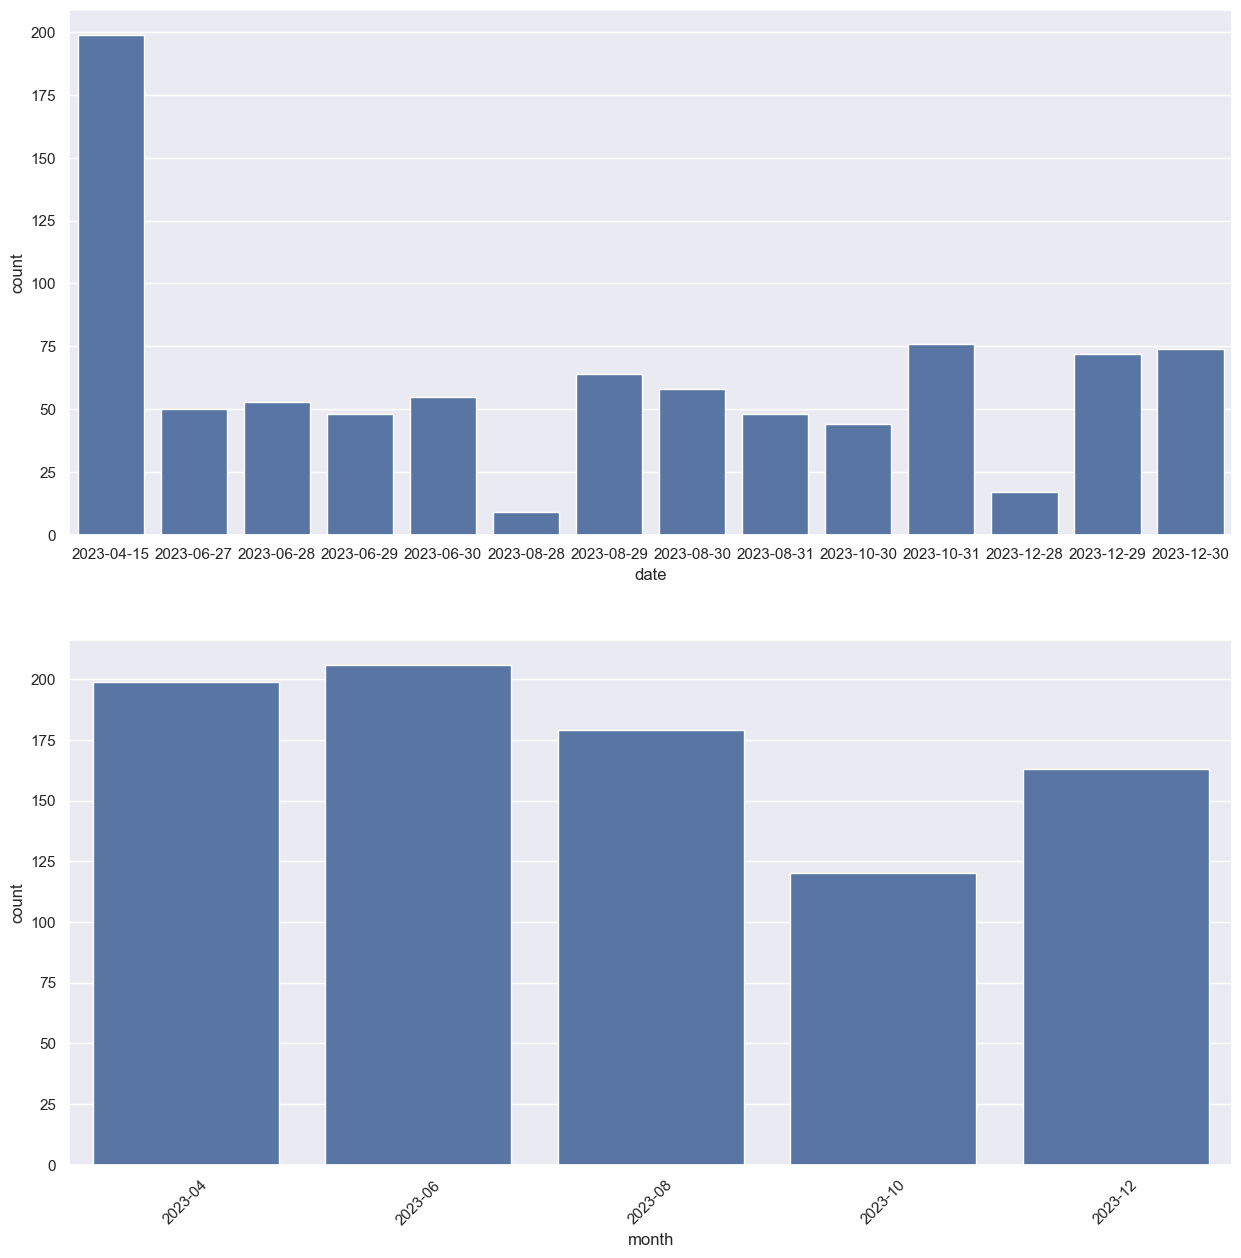

In [8]:
# plot the number of tweets at each date
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 15))

df = df.sort_values('date')
sns.countplot(x='date', data=df, ax=ax1)

df['month'] = df['date'].dt.to_period('M')
sns.countplot(x='month', data=df, ax=ax2)

plt.xticks(rotation=45)
plt.show()


In [ ]:
df_data = df[['anti RSF', 'pro RSF',
       'anti SAF', 'pro SAF', 'Pro peace,', 'anti peace', 'Pro War',
       'anti war', 'pro civilian', 'anti civilians', 'not specified',
       'no polarisation', 'Geopolticis', 'Sudanese', 'Not Sudanese',
       'Sudanese N/A', 'Likely bot', 'Likely not a bot',
       'Cannot be identified.', 'News', 'Not about Sudan']]
fig, ax = plt.subplots(figsize=(10, 5))
df_data.sum().plot(kind='bar', ax=ax)
ax.set_title('Data Distribution')
ax.set_ylim(0, len(df))

In [ ]:
# correlations heatmap 2 floating points
correlation_matrix = df_data.corr()
correlation_matrix = correlation_matrix.round(2)
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

In [ ]:
batch_size= 512
num_epochs = 500
learning_rate = 5e-5
hidden_dim = 2048
train_ds = TweetsDataset(train_embeddings, train_labels)
val_ds = TweetsDataset(val_embeddings, val_labels)
test_ds = TweetsDataset(test_embeddings, test_labels)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
model = TweetClassifer(embeddings_dim, num_classes, hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=calculate_pos_weights(Y))

In [ ]:
logs = {
    'train_loss': [],
    'val_loss': [],
    'train_rocauc':[],
    'val_rocauc':[]
}
val_rocauc_max = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    for x, y in train_dataloader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

    if epoch%5 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for x, y in val_dataloader:
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                val_loss += loss_fn(y_pred, y)

        train_rocauc = score_model(model, train_dataloader)['rocauc']
        val_rocauc = score_model(model, val_dataloader)['rocauc']
        if val_rocauc > val_rocauc_max:
            val_rocauc_max = val_rocauc
            torch.save(model.state_dict(), f'model_{src}_{random_state}_{test_size}.pth')
        print(f'Epoch: {epoch} -- Train Loss: {loss.item() :.4f} RocAuc = {train_rocauc*100 :.4f}|| Val Loss: {val_loss.item() :.4f} RocAuc = {val_rocauc*100 :.4f}')
        
        logs['train_loss'].append(loss.item())
        logs['val_loss'].append(val_loss.item())
        logs['train_rocauc'].append(train_rocauc)
        logs['val_rocauc'].append(val_rocauc)

    torch.save(model.state_dict(), f'lattest_model_{src}_{random_state}_{test_size}.pth')


In [ ]:
logs_path = f'logs_{src}_{random_state}_{test_size}.joblib'
scores_path = f'scores_{src}_{random_state}_{test_size}.joblib'
joblib.dump(logs, logs_path)
if src == 'openai':
    best_model = model
else:
    best_model = TweetClassifer(embeddings_dim, num_classes, hidden_dim=hidden_dim).to(device)
    best_model.load_state_dict(torch.load(f'model_{src}_{random_state}_{test_size}.pth'))
train_score = score_model(best_model, train_dataloader)
val_score = score_model(best_model, val_dataloader)
test_score = score_model(best_model, test_dataloader)
joblib.dump({'train': train_score, 'val': val_score, 'test': test_score}, scores_path)


In [ ]:
src = 'openai'
random_state = 42
test_size = 0.3
labels = ['pro RSF', 'anti RSF', 'anti SAF', 'pro SAF', 'Pro peace,', 'anti peace', 'Pro War',
       'anti war', 'pro civilian', 'anti civilians', 'no polarisation', 'Geopolticis', 'Sudanese', 'Not Sudanese']
logs = joblib.load(f'logs_{src}_{random_state}_{test_size}.joblib')
scores = joblib.load(f'scores_{src}_{random_state}_{test_size}.joblib')
model = TweetClassifer(embeddings_dim, num_classes, hidden_dim=hidden_dim).to(device)
model.load_state_dict(torch.load(f'lattest_model_{src}_{random_state}_{test_size}.pth'))

In [ ]:
logs_df = pd.DataFrame(logs)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(data=logs_df[['train_loss', 'val_loss']], ax=ax[0])
ax[0].set_title('Loss')
sns.lineplot(data=logs_df[['train_rocauc', 'val_rocauc']], ax=ax[1])
ax[1].set_title('RocAuc')
plt.show()

In [ ]:
from collections import defaultdict
metrics = ['precision', 'recall', 'f1', 'accuracy']
labels = ['pro RSF', 'anti RSF', 'anti SAF', 'pro SAF', 'Pro peace', 'anti peace', 'Pro War',
       'anti war', 'pro civilian', 'anti civilians', 'no polarisation', 'Geopolticis', 'Sudanese', 'Not Sudanese']
splits = ['train', 'val', 'test']
scores_df_data = defaultdict(list)
for metric in metrics:
    for split in splits:
        for i in range(len(labels)):
            scores_df_data[f'{split}_{metric}'].append(scores[split][metric][i])
scores_df = pd.DataFrame(scores_df_data, index=labels).T
scores_df['split'] = [x.split('_')[0] for x in scores_df.index]
scores_df['metric'] = [x.split('_')[1] for x in scores_df.index]

# Grouped barplot
fig, axs = plt.subplots(3, 2, figsize=(30, 15))
i = 0
current_metric = 'f1'
for split , df in scores_df.groupby('split'):
    df = df[df['metric'] == current_metric]
    sns.barplot(df, ax=axs[i][0], color='b')
    if split == 'test':
        Y_test.sum(axis=0).plot(kind='bar', ax=axs[i][1])
        n = len(Y_test)
    elif split == 'train':
        Y_train.sum(axis=0).plot(kind='bar', ax=axs[i][1])
        n = len(Y_train)
    else:
        Y_val.sum(axis=0).plot(kind='bar', ax=axs[i][1])
        n = len(Y_val)

    # Write the number of samples on top of the bars
    for p in axs[i][1].patches:
        axs[i][1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    axs[i][0].set_title(f'Split : {split}, n={n}, metric:{current_metric} - Overall AUROC = {scores[split]["rocauc"]*100:.4f}')
    # Vertical line at 0.75
    axs[i][0].axhline(0.75, color='r', linestyle='--', linewidth=1, label='75%')
    # ylimits 0, 1
    axs[i][0].set_ylim(0, 1)
    axs[i][0].set_ylabel('Score')
    axs[i][0].legend()
    i+=1

In [ ]:

def plot_prediction(n, X, Y, codes, model):
    tweet= X.values[n]
    label = Y.values[n]
    code = codes.values[n]
    emb = get_tweets_embeddings([tweet], src=src, codes=[code]).to(device)
    pred = model(emb, logits=True).cpu().detach().numpy().squeeze()
    print(f'Tweet: {tweet}')
    print(f'Truth: {label}')
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.barplot(x=labels, y=pred, ax=ax, hue=label, palette=['red', 'green'])
    ax.set_ylim(0, 1)
    ax.axhline(0.5, color='blue', linestyle='--')
    plt.show()


In [ ]:
n = 244
Y[Y['pro RSF'] == 1].index.values

In [ ]:
plot_prediction(n, X, Y, codes, model)


In [ ]:
n = 716

In [ ]:
f'{5:03d}'

In [ ]:
from eda import read_data
df =  read_data()
df = df[['post', 'code']]
df

In [ ]:
import pandas as pd
pd.read_parquet('openai_large_embs.parquet')

In [ ]:
large_embs = []
for i,row in df.iterrows():
    tweet = row['post']
    code = row['code']
    emb = openai_embedding(client, tweet)
    large_embs.append(emb)

In [ ]:
import openai
def get_embeddings(tweet):
    response = openai.Embedding.create(
        engine="text-davinci-002",
        documents=[tweet],
    )
    return response['embedding']

def main():
    # Assuming your dataframe is named df
    df = pd.read_csv("your_dataframe.csv")  # Read your dataframe

    # Add a key to each tweet
    df['tweet_key'] = df['tweet'].apply(lambda x: f"Key: {x}")

    # Call OpenAI embedding endpoint and save the embeddings
    df['embedding'] = df['tweet'].apply(get_embeddings)

    # Save the embeddings to a new CSV file
    df.to_csv("tweet_embeddings.csv", index=False)

if __name__ == "__main__":
    main()


In [ ]:
import os
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
from transformers import pipeline
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")



class MyDataset(Dataset):
    def __init__(self, items):
        self.items = items

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        return self.items[i]

def init_sentiment_analyzer_pipeline(model='CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment', device='cuda'):
    sa = pipeline('text-classification', model=model,device=device)
    return sa

def init_language_detection_pipeline(model='papluca/xlm-roberta-base-language-detection', device='cuda'):
    ld = pipeline('text-classification', model=model, device=device)
    return ld

def get_arabic_posts(df, ld_pipeline, recreate=False, batch_size=None):
    if not recreate and os.path.exists("arabic_posts.parquet"):
        return pd.read_parquet("arabic_posts.parquet")
    posts = df['post'].tolist()
    posts = [post[:512] for post in posts]
    if batch_size:
        ds = MyDataset(posts)
        languages = []
        i=0
        for lang in tqdm(ld_pipeline(ds, batch_size=batch_size), total=len(posts)):
            i+=1
            languages.append(lang)
    else:
        languages = []
        for i in tqdm(range(len(posts))):
            post = posts[i]
            language = ld_pipeline(post)
            languages.append(language[0])
    languages = [lang['label'] for lang in languages]
    df['language'] = languages
    df = df[df['language'] == 'ar']
    df.to_parquet("arabic_posts.parquet", index=False)
    return df

def get_arabic_sentiment(df, sa_pipeline, recreate=False, batch_size=None):
    if not recreate and os.path.exists("arabic_sentiment.parquet"):
        return pd.read_parquet("arabic_sentiment.parquet")
    posts = df['post'].tolist()
    posts = [post[:512] for post in posts]
    if batch_size:
        ds = MyDataset(posts)
        sentiments = []
        for sent in tqdm(sa_pipeline(ds, batch_size=batch_size), total=len(posts)):
            sentiments.append(sent)
    else:
        sentiments = []
        for i in tqdm(range(len(posts))):
            post = posts[i]
            sentiment = sa_pipeline(post)
            sentiments.append(sentiment)
    sentiments_label = [sent['label'] for sent in sentiments]
    sentiments_polarity = [sent['score'] for sent in sentiments]
    df['sentiment'] = sentiments_label
    df['polarity'] = sentiments_polarity
    df.to_parquet("arabic_sentiment.parquet", index=False)
    return df   


def extract_hashtags(post, unique=True):
    hashtags = [word for word in post.split() if word.startswith("#")]
    if unique:
        hashtags = list(set(hashtags))
    return hashtags


def hashtag_counts(df, recreate=False):
    if not recreate and os.path.exists("hashtag_counts.parquet"):
        return pd.read_parquet("hashtag_counts.parquet")
    hashtags = df['hashtags'].tolist()
    hashtags_flat = [hashtag for sublist in hashtags for hashtag in sublist]
    hashtags_df = pd.DataFrame(hashtags_flat, columns=['hashtag'])
    hashtags_counts = hashtags_df['hashtag'].value_counts()
    hashtags_df = hashtags_counts.reset_index()
    hashtags_df.columns = ['hashtag', 'count']
    hashtags_df = hashtags_df.sort_values(by='count', ascending=False)
    hashtags_df = hashtags_df.reset_index(drop=True)
    hashtags_df.to_parquet("hashtag_counts.parquet", index=False)
    return hashtags_df

def hashtag_sentiment_counts(df, hashtags_df, recreate=False):
    if not recreate and os.path.exists("hashtag_sentiment_counts.parquet"):
        return pd.read_parquet("hashtag_sentiment_counts.parquet")
    df_sentiments = df.groupby('sentiment')
    hashtags = hashtags_df['hashtag'].tolist()
    for sentiment, group in df_sentiments:
        sentiment_count = []
        for hashtag in hashtags:
            count = 0
            for hashtags_list in group['hashtags']:
                if hashtag in hashtags_list:
                    count += 1
            sentiment_count.append(count)
        hashtags_df[sentiment] = sentiment_count
    hashtags_df['sentiment'] = hashtags_df[['negative', 'neutral', 'positive']].idxmax(axis=1)
    hashtags_df.to_parquet("hashtag_sentiment_counts.parquet", index=False)
    return hashtags_df

def keyword_in_post(post, keywords):
    for keyword in keywords:
        if keyword in post:
            return True
    return False

def filter_post(post):
    relevant_keywords = ['سودان', 'البرهان', 'حميدتي', 'حميدتى', 'السودان', 'الدعم السريع', '#الدعم_السريع' , 'الدعم_السريع', 'دقلو', 'الجنجويد', 'جنجويد', 'القوات المسلحة', 'الجياشة', 'جياشة']
    not_relevant_keywords = ['فلسطين', 'غزة', 'الإسرائيلي', 'إسرائيل','الصهيوني', 'الجنوبي', 'اليمني', 'الروسي', 'أوكرانيا', 'روسيا', 'السعودي', 'اللبناني', 'المصرى']
    relevant = keyword_in_post(post, relevant_keywords)
    not_relevant = keyword_in_post(post, not_relevant_keywords)
    if relevant and not not_relevant:
        # print("Only relevant Keywords in post")
        # print(post)
        # print()
        label = 1 # Only relevant
    if not relevant and not_relevant:
        # print("Only not relevant Keywords in post")
        # print(post)
        # print()
        label = -1 # Only not relevant
    if relevant and not_relevant:
        # print("Mixed Keywords in post")
        # print(post)
        # print()
        label = 1 # relevant and not relevant
    if not relevant and not not_relevant:
        # print("Neither relevant nor not relevant Keywords in post")
        # print(post)
        # print()
        label = 1 # neither relevant nor not relevant
    return label




In [ ]:
df = pd.read_csv("combined_reports.csv")
df['relevance'] = df['post'].apply(filter_post)
num_relevant = len(df[df['relevance'] == 1])
num_not_relevant = len(df[df['relevance'] == -1])
print(f"Percentage of Not Relevant Posts: {num_not_relevant/len(df)*100:.2f}% ({num_not_relevant}/{len(df)})")

random_sample_size = 900
random_seed = 51

df_relevant = df[df['relevance'] == 1].reset_index(drop=True)

df_relevant_sample = df_relevant.sample(n=random_sample_size, random_state=random_seed)
df_relevant_rest = df_relevant.drop(df_relevant_sample.index)

df_relevant_sample.reset_index(drop=True, inplace=True)
df_relevant_rest.reset_index(drop=True, inplace=True)


random_sample_path = f"random_sample_{random_sample_size}_{random_seed}.csv"
df_relevant_sample.to_csv(random_sample_path, index=False)
print(f"Random Sample of {random_sample_size} Relevant Posts saved to {random_sample_path}")

random_rest_path = f"random_rest_{random_sample_size}_{random_seed}.csv"
df_relevant_rest.to_csv(random_rest_path, index=False)
print(f"Rest of Relevant Posts ({len(df_relevant_rest)}) saved to {random_rest_path}")

df_not_relevant = df[df['relevance'] == -1].reset_index(drop=True)
not_relevant_path = "not_relevant.csv"
df_not_relevant.to_csv(not_relevant_path, index=False)

print(f"Rest of Not Relevant Posts ({len(df_not_relevant)}) saved to {not_relevant_path}")


print("Done, CSV Shapes:")
print(f"Combined Reports: {pd.read_csv('combined_reports.csv').shape}")
print(f"Random Sample: {pd.read_csv(random_sample_path).shape}")
print(f"Random Rest: {pd.read_csv(random_rest_path).shape}")
print(f"Not Relevant: {pd.read_csv(not_relevant_path).shape}")





#Summary:
#1. I created the file combined_reports.csv by combining the reports from the all periods. It's shape is 175008 rows, 16 columns.
#2. I filtered the posts based on the following:
#   - relevant_keywords = ['سودان', 'البرهان', 'حميدتي', 'السودان', 'الدعم السريع', 'دقلو']
#   - not_relevant_keywords = ['فلسطين', 'غزة', 'الإسرائيلي', 'إسرائيل', 'الجنوبي', 'اليمني', 'الروسي', 'أوكرانيا', 'روسيا']
#   - If a post contains any of the Not Relevant Keywords and None of the Relevant Keywords, it is labeled as -1 (Not Relevant)
#   - Otherwise, the post is labeled as 1 (Relevant)
#   - This resulted in 17.48% (30597/175008) of the posts being labeled as Not Relevant
#3. I randomly sampled 900 posts from the Relevant Posts Using a the sample function in pandas with a random seed of 51.
#4. The random sample of 900 posts was saved to random_sample_900_51.csv. It's shape is 900 rows, 17 columns.
#5. The rest of the Relevant Posts (175008-30597-900=143511) were saved to random_rest_900_51.csv. It's shape is 143511 rows, 17 columns.
#6. The Not Relevant Posts were saved to not_relevant.csv. It's shape is 30597 rows, 17 columns.




In [ ]:
nr = pd.read_csv(not_relevant_path)
keyword = 'الجيش'
nr['contains_keyword'] = nr['post'].apply(lambda x: keyword in x)
nr[nr['contains_keyword'] == True].sample(5)['post'].tolist()

In [ ]:
nr.contains_keyword.value_counts()

In [ ]:
# r = pd.read_csv(random_rest_path)
keyword = 'الجيش'
r['contains_keyword'] = r['post'].apply(lambda x: keyword in x)
r[r['contains_keyword'] == True].sample(5)['post'].tolist()

In [ ]:
df_relevant_sample['month'] = df_relevant_sample['date'].apply(lambda x: x.split('-')[1])
df_relevant_sample.month.value_counts().plot(kind='bar')

In [ ]:
df_relevant_sample.sample(5)['post'].tolist()

In [ ]:
df_relevant = df[df['relevance'] == 1]
df_not_relevant = df[df['relevance'] == -1]

In [ ]:
print("Number of relevant posts", len(df_relevant))
print("Number of not relevant posts", len(df_not_relevant))

In [ ]:
30597/ (30597+144411)

In [ ]:
ps = df_army.sample(5)['post'].tolist()
for p in ps:
    print(p)
    print()

In [ ]:
print(f"Original data shape: {df.shape}")
df = get_arabic_posts(df, None)
print(f"Arabic data shape: {df.shape}")
df = get_arabic_sentiment(df, None)
print(f"Arabic sentiment data shape: {df.shape}")
df['hashtags'] = df['post'].apply(extract_hashtags)
hashtags_df = hashtag_counts(df)
print(f"Hashtag counts shape: {hashtags_df.shape}")
hashtags_df = hashtag_sentiment_counts(df, hashtags_df)
print(f"Hashtag sentiment counts shape: {hashtags_df.shape}")


In [ ]:
keyword_ar = "الإسرائيلي"
keyword_ar2 = "إسرائيل"
keyword_ar3 = "فلسطين"
keyword_ar4 = "غزة"



# df_keyword = df[df['post'].str.contains(keyword_ar, case=False)]

df_keyword = df[df['post'].str.contains(keyword_ar, case=False) | df['post'].str.contains(keyword_ar2, case=False) | df['post'].str.contains(keyword_ar3, case=False) | df['post'].str.contains(keyword_ar4, case=False)]

df_not_keyword = df[~df['post'].str.contains(keyword_ar, case=False) & ~df['post'].str.contains(keyword_ar2, case=False) & ~df['post'].str.contains(keyword_ar3, case=False) & ~df['post'].str.contains(keyword_ar4, case=False)]

In [ ]:
import plotly.graph_objects as go

df_keyword_plot = df_keyword.groupby('date').size().reset_index(name='count')

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_keyword_plot['date'],
    y=df_keyword_plot['count'],
    name='Posts containing keyword',
))

#Add also the number of posts that do not contain the keyword

df_not_keyword_plot = df_not_keyword.groupby('date').size().reset_index(name='count')

fig.add_trace(go.Bar(
    x=df_not_keyword_plot['date'],
    y=df_not_keyword_plot['count'],
    name='Posts without keyword',
))

fig.update_layout(
    barmode='stack',
    title=f'Posts containing {keyword_ar} and {keyword_ar2} and {keyword_ar3} and {keyword_ar4}',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Number of posts'),
    showlegend=True
)


#save the pl
fig.show()


In [ ]:
df_keyword.shape

In [ ]:
#plot frequency of posts with keyword based on date
df_keyword['date'] = pd.to_datetime(df_keyword['date'])
df_keyword = df_keyword.sort_values(by='date')
df_keyword['date'] = df_keyword['date'].dt.date
df_keyword['date'] = pd.to_datetime(df_keyword['date'])
df_keyword = df_keyword.groupby('date').size().reset_index(name='count')
df_not_keyword['date'] = pd.to_datetime(df_not_keyword['date'])
df_not_keyword = df_not_keyword.sort_values(by='date')
df_not_keyword['date'] = df_not_keyword['date'].dt.date
df_not_keyword['date'] = pd.to_datetime(df_not_keyword['date'])
df_not_keyword = df_not_keyword.groupby('date').size().reset_index(name='count')
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=df_keyword, x='date', y='count', ax=ax, label='Not relevant posts')
sns.lineplot(data=df_not_keyword, x='date', y='count', ax=ax, label='Relevant posts')
plt.title(f"Frequency of posts about Sudan vs else")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.savefig("not_relevant_posts.png")
# plt.figure(figsize=(15, 6))
# sns.lineplot(data=df_keyword, x='date', y='count')
# plt.title(f"Frequency of posts with keyword about Israel and Palestine")
# plt.xlabel("Date")
# plt.ylabel("Count")
# plt.xticks(rotation=45)
# plt.savefig("not_relevant_posts.png")
# plt.show()


In [ ]:
p = df_keyword.sample(10)
for i, row in p.iterrows():
    print(row['post'])


In [ ]:
#Create a WordCloud from the text (Use the WordCloud library and Arabic reshaper library)
from wordcloud import WordCloud
from arabic_reshaper import reshape
from bidi.algorithm import get_display
import re
import emoji
import nltk
from nltk.corpus import stopwords


def removeWeirdChars(text):
    weirdPatterns = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               u"\u2069"
                               u"\u2066"
                               u"\u200c"
                               u"\u2068"
                               u"\u2067"
                               "]+", flags=re.UNICODE)
    return weirdPatterns.sub(r'', text)

def remove_eng(text):
    return re.sub(r'[a-zA-Z]', '', text)


def filter_arabic_stopwords(text):
    stop_words = set(stopwords.words('arabic'))
    return ' '.join([word for word in text.split() if word not in stop_words])



all_text = df.sample(100000)['post'].tolist()
text = " ".join(all_text)
text = removeWeirdChars(text)
text = remove_eng(text)
text = emoji.replace_emoji(text, replace='', version=-1)
text = filter_arabic_stopwords(text)



In [ ]:
reshaped_text = reshape(text)
bidi_text = get_display(reshaped_text)


In [ ]:

wordcloud = WordCloud(font_path='arial', background_color='white', width=800, height=400).generate(bidi_text)
plt.figure(figsize=(30, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.png')
plt.show()

In [ ]:
#use counter to count the most common words in the text
from collections import Counter
words = text.split()
counter = Counter(words)

In [ ]:
most_common = counter.most_common(20)
most_common

In [ ]:
keyword_dict = {
'places': ['سودان', 'خرطوم', 'دارفور', 'نيالا', 'الفاشر', 'الجنينة', 'زالنجي', 'مدني', 'الجزيرة'],
'entities': ['جيش',  'امارات', 'سعودي', 'مصر', 'ليبي', 'تشاد',  'قوة الحرية و التغيير', 'قوة_الحرية_و_التغيير'],
'people': ['السيسي', 'برهان', 'حميدتي', 'حفتر', 'بن راشد', 'بن سلمان', 'دقلو'],
'groups': ['جنجويد', 'دعام', 'اخوان', 'كيزان', 'بلابسة', 'قحت', 'قحاتة', 'جياشة', 'إيقاد'],
'events': ['حرب', 'اشتباك', 'انقلاب', 'وساطة', 'هدنة', 'جدة'],
}

In [ ]:
def count_keyword_posts(df, keyword):
    keyword_posts = df[df['post'].str.contains(keyword, case=False)]
    return keyword_posts


In [ ]:
import plotly.graph_objects as go

df_plot = df.groupby('date').size().reset_index(name='count')

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_plot['date'],
    y=df_plot['count'],
    name='Posts',
))

fig.update_layout(
    width=1500,
    height=700,
    autosize=True,
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Posts")


# selected_category = 'entities'
selected_category = 'places'
# selected_category = 'people'
# selected_category = 'groups'
# selected_category = 'events'


#keyword button
buttons = []
for keyword in keyword_dict[selected_category]:
    button = dict(
                 label=keyword,
                 method="update",
                 args=[{"x": [df_plot['date']], "y": [count_keyword_posts(df, keyword).groupby('date').size().reset_index(name='count')['count']]}]
    )
    buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction="down",
        ),
    ]
)


fig.show()

In [ ]:
top_users= df.groupby('username').sum().sort_values(by='impressions', ascending=False).head(50).index
for username in top_users:
    user = df[df['username'] == username]['user'].reset_index(drop=True)[0]
    print(f"{username} - {user}")

In [ ]:
username = '@salma1siddig'
#plot posts of a user over time
fig = go.Figure()

df_plot = df[df['username'] == username].groupby('date').size().reset_index(name='count')

fig.add_trace(go.Bar(
    x=df_plot['date'],
    y=df_plot['count'],
    name='Posts',
))


fig.update_layout(
    width=1500,
    height=700,
    autosize=True,
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Posts")

fig.show()

In [ ]:
#ignore warnings
import warnings

warnings.filterwarnings("ignore")

In [ ]:
report_files_to_drop = ['Report 1', 'Report 1-1', 'Report 1-2', 'Report 1-3']
df_dropped = df[~df.report_file.isin(report_files_to_drop)]

In [ ]:
#plot number of negative, neutral and positive posts over time
df_plot = df.groupby(['date', 'sentiment']).size().reset_index(name='count')

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df_plot[df_plot['sentiment'] == 'negative']['date'],
    y=df_plot[df_plot['sentiment'] == 'negative']['count'],
    name='Negative',
    
))

fig.add_trace(go.Bar(
    x=df_plot[df_plot['sentiment'] == 'neutral']['date'],
    y=df_plot[df_plot['sentiment'] == 'neutral']['count'],
    name='Neutral',
))

fig.add_trace(go.Bar(
    x=df_plot[df_plot['sentiment'] == 'positive']['date'],
    y=df_plot[df_plot['sentiment'] == 'positive']['count'],
    name='Positive',
))

fig.update_layout(
    width=2000,
    height=700,
    autosize=True,
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Posts")


In [ ]:
df_plot = df.groupby('date').size().reset_index(name='count')

In [ ]:
df_plot

In [ ]:
#Distribution of the collected tweets over time (bar chart)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
date_counts = df['date'].value_counts().reset_index()
date_counts.columns = ['date', 'count']
date_counts = date_counts.sort_values('date')
plt.figure(figsize=(15, 5))
#all bars to be of the same color
sns.barplot(x='date', y='count', data=date_counts, color='skyblue')
plt.xticks(rotation=90)
plt.title("Tweets Over Time")
plt.show()



In [ ]:
#Number of occurrences of the hashtags in all tweets per day
days_df = df.groupby('date')
hashtags = hashtags_df['hashtag'].tolist()
for day, group in days_df:
    day_count = []
    for hashtag in hashtags:
        count = 0
        for hashtags_list in group['hashtags']:
            if hashtag in hashtags_list:
                count += 1
        day_count.append(count)
    hashtags_df[day] = day_count


In [ ]:
hashtags_df_sample = hashtags_df.head(10)

In [ ]:
#Plot the distribution of the hashtags over time
import datetime
from bidi.algorithm import get_display
from arabic_reshaper import reshape
cols = [col for col in hashtags_df.columns if '2023' in col]
cols += ['hashtag']
fig, ax = plt.subplots(figsize=(15, 5))
hashtags_df_sample[cols].set_index('hashtag').T.plot.area(ax=ax, legend=True, colormap='tab20')
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for text in legend.texts:
    text.set_text(get_display(reshape(text.get_text())))
#place the legend outside the plot to the right
plt.title("Hashtags Over Time")
plt.show()



In [ ]:
#Plot the distribution of the hashtags over time but this time split the positive and negative hashtags

cols = [col for col in hashtags_df.columns if '2023' in col]
positive_hashtags = hashtags_df[hashtags_df['sentiment'] == 'positive']
negative_hashtags = hashtags_df[hashtags_df['sentiment'] == 'negative']

positive_hashtags = positive_hashtags.sort_values('count', ascending=False).head(10)
negative_hashtags = negative_hashtags.sort_values('count', ascending=False).head(10)

for col in cols:
    positive_hashtags[col] = positive_hashtags[col]
    negative_hashtags[col] = negative_hashtags[col] * -1
cols += ['hashtag']
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)
ax_up, ax_down = axs
positive_hashtags[cols].set_index('hashtag').T.plot.area(ax=ax_up, legend=False, colormap='Blues')
negative_hashtags[cols].set_index('hashtag').T.plot.area(ax=ax_down, legend=False, colormap='Reds')
ax_down.xaxis.tick_top()
bottom_legend = ax_down.legend()
for text in bottom_legend.texts:
    text.set_text(get_display(reshape(text.get_text())))
top_legend = ax_up.legend()
for text in top_legend.texts:
    text.set_text(get_display(reshape(text.get_text())))
plt.show()

In [ ]:
#count the number of tweets for each user in a new dataframe
users_df = df['username'].value_counts().reset_index()
users_df.columns = ['user', 'count']
users_df = users_df.sort_values('count', ascending=False)

In [ ]:
#For each user, calculate the number of positive, negative, and neutral tweets
users = users_df['user'].tolist()
df_users = df.groupby('username')
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_count = []
    for user in users:
        count = 0
        for user_tweets in df_users.get_group(user)['sentiment']:
            if user_tweets == sentiment:
                count += 1
        sentiment_count.append(count)
    users_df[sentiment] = sentiment_count


In [ ]:
users_df.head(10)

In [ ]:
#Create a dataframe indexed by the date and with columns for each user number of positive, negative, and neutral tweets
dates = df['date'].unique()
users = users_df['user'].tolist()

users_sentiments_df_pos = pd.DataFrame(index=dates, columns=users)
users_sentiments_df_pos = users_sentiments_df_pos.fillna(0)

df_positive = df[df['sentiment'] == 'positive']
df_positive = df_positive.groupby('date')
for date, group in df_positive:
    for user in users:
        users_sentiments_df_pos.at[date, user] = group['username'].value_counts().get(user, 0)
users_sentiments_df_neg = pd.DataFrame(index=dates, columns=users)
users_sentiments_df_neg = users_sentiments_df_neg.fillna(0)
df_negative = df[df['sentiment'] == 'negative']
df_negative = df_negative.groupby('date')
for date, group in df_negative:
    for user in users:
        users_sentiments_df_neg.at[date, user] = group['username'].value_counts().get(user, 0)

        

In [ ]:
# For a specific user, plot the number of positive and negative tweets over time
target_user = '@AJABreaking'
user_df = df[df['username'] == target_user]
user_df['date'] = pd.to_datetime(user_df['date'])
user_df = user_df.sort_values('date')
user_df = user_df.set_index('date')
user_df = user_df.resample('D').count()
user_df = user_df[['post']]
user_df.columns = ['count']
user_df['positive'] = users_sentiments_df_pos[target_user]
user_df['negative'] = users_sentiments_df_neg[target_user]
user_df = user_df.fillna(0)
user_df = user_df.reset_index()
user_df['date'] = user_df['date'].dt.date
plt.figure(figsize=(15, 5))
plt.plot(user_df['date'], user_df['positive'], label='Positive', color='green')
plt.plot(user_df['date'], user_df['negative'], label='Negative', color='red')
plt.xticks(rotation=90)
plt.legend()